In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd

import rioxarray as rxr
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
ucrb_subbasins = gpd.read_file('../basin_characteristics/ucrb_huc06_co.geojson')
ucrb_subbasins = ucrb_subbasins[ucrb_subbasins['HU6NAME'].isin([
    'Yampa',
    'Colorado',
    'White',
    'Dolores',
    'San Juan',
    'Gunnison'
])]

hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_crs('32613', allow_override=True)
hcdn_basins = hcdn_basins.set_index('gage')
hcdn_basins = hcdn_basins.to_crs(ucrb_subbasins.crs)
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]

hcdn_centroid_gdf = gpd.GeoDataFrame(hcdn_basins.centroid)
hcdn_centroid_gdf = hcdn_centroid_gdf.rename(columns={0:'geometry'})


/tmp/ipykernel_29701/2127124952.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hcdn_centroid_gdf = gpd.GeoDataFrame(hcdn_basins.centroid)


<AxesSubplot: >

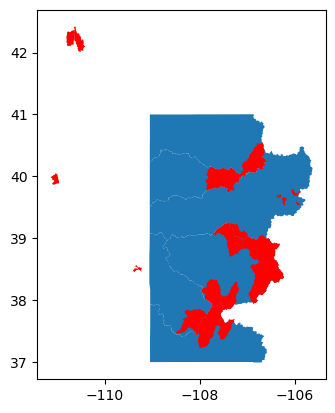

In [3]:
fig, ax = plt.subplots()
ucrb_subbasins[ucrb_subbasins['HU6NAME'].isin([
    'Yampa',
    'Colorado',
    'White',
    'Dolores',
    'San Juan',
    'Gunnison'
])].plot(ax=ax)
hcdn_basins.plot(color='r',ax=ax)

In [3]:
hcdn_huc6 = ucrb_subbasins.sjoin(hcdn_centroid_gdf, how='right', predicate='contains')['HU6NAME']
hcdn_basins = hcdn_basins.merge(hcdn_huc6, left_index=True, right_index=True)

In [13]:
hcdn_streamflow_daily_ds = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc')

In [14]:
hcdn_streamflow_daily_ds

<xarray.Dataset>
Dimensions:          (year: 128, site_no: 26)
Coordinates:
  * site_no          (site_no) object '09034900' '09035900' ... '09361500'
  * year             (year) int64 1895 1896 1897 1898 ... 2019 2020 2021 2022
    dim_1            object ...
Data variables: (12/13)
    00060_Mean       (year, site_no) float64 ...
    WY               (year, site_no) float64 ...
    basin_area       (year, site_no) float64 ...
    elevation        (year, site_no) float32 ...
    north            (year, site_no) float64 ...
    south            (year, site_no) float64 ...
    ...               ...
    elevation_range  (year, site_no) float64 ...
    x                (year, site_no) float64 ...
    y                (year, site_no) float64 ...
    q_mm_day         (year, site_no) float64 ...
    ppt              (year, site_no) float64 ...
    q_mm             (year, site_no) float64 ...

In [15]:
runoff_efficinecy = hcdn_streamflow_daily_ds['q_mm']/hcdn_streamflow_daily_ds['ppt']
runoff_efficinecy.name = 'RE'
re_20 = runoff_efficinecy.quantile(.20, dim='year')
re_80 = runoff_efficinecy.quantile(.80, dim='year')

In [17]:
# runoff_efficinecy.to_netcdf('../data/streamflowdata/hcdn_runoff_efficiency.nc')

Text(0.5, 1.0, 'San Juan and Dolores Rivers')

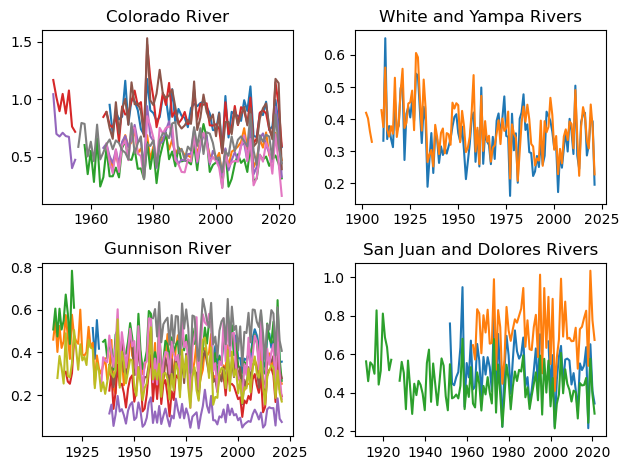

In [7]:
re_df = runoff_efficinecy.to_dataframe().reset_index()
fig, axs = plt.subplots(2,2, tight_layout=True)
CO_re = re_df[re_df['site_no'].isin(hcdn_basins[hcdn_basins['HU6NAME']=='Colorado'].index)]
for site in CO_re.site_no.unique():
    axs[0,0].plot(CO_re[CO_re['site_no']==site].year,CO_re[CO_re['site_no']==site].RE)
    
GU_re = re_df[re_df['site_no'].isin(hcdn_basins[hcdn_basins['HU6NAME']=='Gunnison'].index)]
for site in GU_re.site_no.unique():
    axs[1,0].plot(GU_re[GU_re['site_no']==site].year,GU_re[GU_re['site_no']==site].RE)

WH_YA_re = re_df[re_df['site_no'].isin(hcdn_basins[hcdn_basins['HU6NAME'].isin(['White','Yampa'])].index)]
for site in WH_YA_re.site_no.unique():
    axs[0,1].plot(WH_YA_re[WH_YA_re['site_no']==site].year,WH_YA_re[WH_YA_re['site_no']==site].RE)

SJ_DO_re = re_df[re_df['site_no'].isin(hcdn_basins[hcdn_basins['HU6NAME'].isin(['San Juan','Dolores'])].index)]
for site in SJ_DO_re.site_no.unique():
    axs[1,1].plot(SJ_DO_re[SJ_DO_re['site_no']==site].year,SJ_DO_re[SJ_DO_re['site_no']==site].RE)

axs[0,0].set_title('Colorado River')
axs[1,0].set_title('Gunnison River')
axs[0,1].set_title('White and Yampa Rivers')
axs[1,1].set_title('San Juan and Dolores Rivers')

Pull in basin q and p for UCRB and get the length of each time series of HCDN basins

In [27]:
ucrb_basin_q_p = pd.read_csv('../data/streamflowdata/ucrb_basin_q_p.csv', index_col=0)
streamflow_len = [(~np.isnan(hcdn_streamflow_daily_ds.sel(site_no=site)['q_mm'].values)).sum() for site in hcdn_streamflow_daily_ds.site_no]
streamflow_len_dict = dict(zip(list(hcdn_streamflow_daily_ds.site_no.values),streamflow_len))

Calculate the runoff ratio for the UCRB over the entire time series

In [8]:
ucrb_re = ucrb_basin_q_p['annual_flow_km3']/ucrb_basin_q_p['p_km3']

Calculate the years above the 80th percentile in runoff effeciency and below the 20th percentile in runoff efficiency for the UCRB

In [137]:
ucrb_lowest = ucrb_re[ucrb_re < np.percentile(ucrb_re,20)]
ucrb_lowest_years = pd.Series(ucrb_lowest.index)
ucrb_lowest_years.name='UCRB'
ucrb_highest = ucrb_re[ucrb_re > np.percentile(ucrb_re,80)]
ucrb_highest_years = pd.Series(ucrb_highest.index)
ucrb_highest_years.name='UCRB'

Calculate the years above the 80th percentile in runoff effeciency and below the 20th percentile in runoff efficiency for the HCDN basins

In [10]:
hcdn_re_highest = runoff_efficinecy.where(runoff_efficinecy>re_80).to_dataframe().dropna().reset_index()
hcdn_re_lowest = runoff_efficinecy.where(runoff_efficinecy<re_20).to_dataframe().dropna().reset_index()

Create a dictionary to hold the years with lowest runoff efficiency in the HCDN basins

Find the years that match between each basin and the UCRB as a whole, in terms of the 80th percentile of runoff ratio. Also I normalized these to the length of the entire record


In [188]:
runoff_efficinecy_dict_high = {}
for site in hcdn_re_highest.site_no.unique():
    runoff_efficinecy_dict_high[site] = hcdn_re_highest[hcdn_re_highest.site_no==site].year

In [189]:
matching_years_high = {}
for k,v in runoff_efficinecy_dict_high.items():
    matching_years_high[k] = ucrb_highest.reset_index().rename(columns={'index':'year'}).merge(v,on=['year'])

ss_high = [v.rename(columns={'year':k})[k] for k,v in matching_years_high.items()]
ss_high.append(ucrb_highest_years)
df_high = pd.concat([s[s.ne("")].reset_index(drop=True) for s in ss_high], 1)

# Set the percentage threshold
percentage_threshold = 0.3

# Calculate the minimum number of columns required
min_columns_required = int(len(df_high.columns) * percentage_threshold)

# Find values present in at least 30% of the columns
common_values_high = {}
for val in df_high['UCRB'].values:
    tmp = df_high[df_high == val]
    common_values_high[val] = (np.array([len(tmp[col].dropna()) for col in tmp.columns]).sum() - 1) > min_columns_required

total_years_high = np.array(list(common_values_high.values())).sum()

/tmp/ipykernel_9793/4231421293.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_high = pd.concat([s[s.ne("")].reset_index(drop=True) for s in ss_high], 1)


Find the years that match between each basin and the UCRB as a whole, in terms of the 20th percentile of runoff ratio. Also I normalized these to the length of the entire record


In [190]:
runoff_efficinecy_dict_low = {}
for site in hcdn_re_lowest.site_no.unique():
    runoff_efficinecy_dict_low[site] = hcdn_re_lowest[hcdn_re_lowest.site_no==site].year

In [191]:
matching_years_low = {}
for k,v in runoff_efficinecy_dict_low.items():
    matching_years_low[k] = ucrb_lowest.reset_index().rename(columns={'index':'year'}).merge(v,on=['year'])

ss_low = [v.rename(columns={'year':k})[k] for k,v in matching_years_low.items()]
ss_low.append(ucrb_lowest_years)
df_low = pd.concat([s[s.ne("")].reset_index(drop=True) for s in ss_low], 1)

# Set the percentage threshold
percentage_threshold = 0.3

# Calculate the minimum number of columns required
min_columns_required = int(len(df_low.columns) * percentage_threshold)

# Find values present in at least 30% of the columns
common_values_low = {}
for val in df_low['UCRB'].values:
    tmp = df_low[df_low == val]
    common_values_low[val] = (np.array([len(tmp[col].dropna()) for col in tmp.columns]).sum() - 1) > min_columns_required

total_years_low = np.array(list(common_values_low.values())).sum()

/tmp/ipykernel_9793/309610575.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_low = pd.concat([s[s.ne("")].reset_index(drop=True) for s in ss_low], 1)


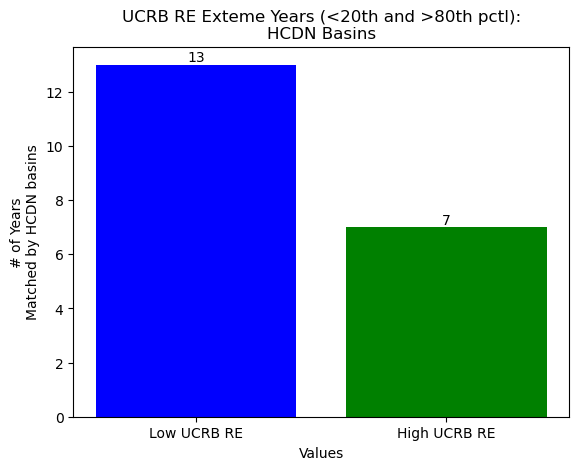

In [192]:
import matplotlib.pyplot as plt

# Define the data for the bar plot
values = [total_years_low, total_years_high]  # Example values for two bars
labels = ['Low UCRB RE', 'High UCRB RE']  # Labels for the bars
colors = ['blue', 'green']  # Colors for the bars

# Create the bar plot with different colors
plt.bar(labels, values, color=colors)

# Add labels to the bars
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add axis labels and title
plt.xlabel('Values')
plt.ylabel('# of Years\nMatched by HCDN basins')
plt.title('UCRB RE Exteme Years (<20th and >80th pctl):\nHCDN Basins')

# Display the plot
plt.show()
